# Note
This jupyter notebook is used to train simple model to predict emo-denoting words from the BERT prediction output

### Training Data Preparation
* Part of the BERT prediction output shall be labelled with 1/0 for emotion-denoting under a 'Label' column
* The labelled part of the data are used in the supervised training with 30% of them used as validation set
* **bert_output_path** is a variable for you to pass the path of the bert model prediction output from the BERT model prediction notebook

### Model Training
* Three models (random forest, decision tree, logistic regression) are included in the code for your model selection , feature importance, accuracy and f1-score on the test set
* Change **model_select** variable to the desired one

### Model Prediction result
* Ouput file name **emo_pred_file_name** can be modified in the first cell

In [1]:
import pandas as pd
import random
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import pickle


### folder directory
output_folder="../output/"
model_save_folder = "../models/"


### read the BERT output csv file with "emo?" label 
bert_output_path = "../output/bert_final_output.csv"
emo_pred_file_name="pred_with_rfc"
### 

## Model input data processing

In [2]:
bert_output =pd.read_csv(bert_output_path)

## reformat the input from bert prediction
input_text = bert_output[['index','Label','self_auth','self_deg','self_betcent','pred_auth','pred_deg','pred_betcent','from_textid']]
# bert_y=bert_output['Emo']

## get the training data for the emo-denoting word prediction , get those data with "Label"
for col in ['self_auth','self_deg','self_betcent']:
    input_text.loc[input_text['Label'].isna(),col]=-1
    
## calculate average auth score from the BERT predicted words
def cal_avg_pred_score(row):
    count = 0
    sum_ = 0
    for item in row:
        item = item.strip()
        if item != '-1':
            sum_ += float(item)
            count+= 1
    if count==0:
        return 0
    else:
        return sum_/count

### convert string list to float list for further 
for col in ['pred_auth','pred_deg','pred_betcent']:
    input_text[col] = input_text[col].str.replace("'","",).str.replace("[","").str.replace("]","").str.split(',')

### col avg calculation 
for col in ['pred_auth','pred_deg','pred_betcent']:
    input_text['avg_'+col]= input_text[col].map(lambda x: cal_avg_pred_score(x))
    
### columns to fit the model    
input_col = ['self_auth','self_deg','self_betcent','avg_pred_auth','avg_pred_deg','avg_pred_betcent']


/Users/nanyang/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/nanyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/nanyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

## Training data processing

In [32]:
#training data input 
data_X = input_text.loc[~bert_y.isna(),input_col]
data_Y = bert_y[~bert_y.isna()]


In [11]:
## train and val data split
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.2, random_state=0)

## Model selection Proces

Accuracy: 0.8811881188118812
f1 score: 0.5862068965517241


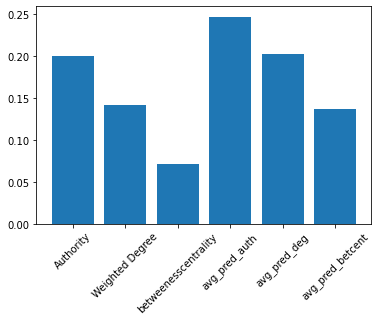

In [16]:
### fit training data on Random Forest Classifier

rfc = RandomForestClassifier(n_estimators=20, random_state=0)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

### display feature importances
plt.bar([X_train.columns[x] for x in range(len(rfc.feature_importances_))], rfc.feature_importances_)
plt.xticks(rotation=45)

## calcualte accuracy and f1 score
print('Accuracy:', np.sum(y_pred == y_test) / len(y_test))
print("f1 score:", metrics.f1_score(y_test,y_pred))

Accuracy 0.7970297029702971
f1 score: 0.5060240963855421


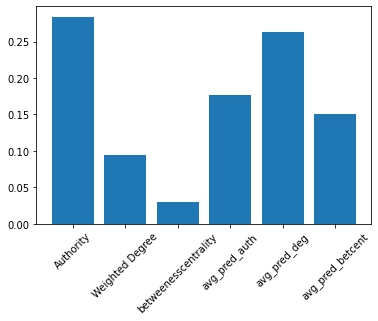

In [17]:
### fitting data on to decision tree

dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
y_pred_dt = dt.predict(X_test)

### display feature importances
plt.bar([X_train.columns[x] for x in range(len(dt.feature_importances_))], dt.feature_importances_)
plt.xticks(rotation=45)

## calcualte accuracy and f1 score
print('Accuracy', np.sum(y_pred_dt == y_test) / len(y_test))
print("f1 score:",metrics.f1_score(y_test,y_pred_dt))

Feature: Authority, Score: 0.66322
Feature: Weighted Degree, Score: 0.00419
Feature: betweenesscentrality, Score: -0.00000
Feature: avg_pred_auth, Score: 0.02018
Feature: avg_pred_deg, Score: 0.00336
Feature: avg_pred_betcent, Score: -0.00001


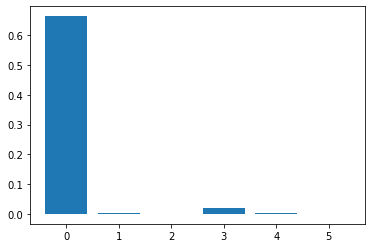

Accuracy: 0.8366336633663366
f1 score: 0.26666666666666666


In [18]:
### fitting data to logistic regression model

lg = LogisticRegression()
lg.fit(X_train, y_train)

# summarize feature importance
importance = lg.coef_[0]
for i,v in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (X_train.columns[i],v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## evaluation on test set
y_pred_lg=lg.predict(X_test)
print('Accuracy:', np.sum(y_pred_lg == y_test) / len(y_test))
print('f1 score:',metrics.f1_score(y_test,y_pred_lg))

### Save Model and predict on the unlabelled data

In [19]:
## predict the unlabelled data using the selected model

"""
options for model_select : 
rfc => random forest classifier
dt => decision tree
lg => logistic regression
"""
##### change accordingly
model_select = rfc
#####

#### make prediction on unlabelled rows of input_text
new_X = input_text.loc[bert_y.isna(),input_col]
y_pred = model_select.predict(new_X)

### save the selected model for future use

filename = 'emo-prediction_rft_model'
pickle.dump(model_select, open(model_save_folder +filename, 'wb'))

In [20]:
### make new dataframe to output 
res = new_X.copy()
res['word'] = bert_output.loc[bert_y.isna(),'index']
res['emo?'] = y_pred
res['textid']=bert_output.loc[bert_y.isna(),'from_textid']

In [24]:
res.to_csv(emo_pred_file_name+".csv",index=False)

## Prediction using saved model

In [5]:
model_file_path = "emo-prediction_rft_model"
loaded_model = pickle.load(open(model_save_folder + model_file_path, 'rb'))

result = loaded_model.predict(input_text[input_col])
res = input_text[input_col].copy()
res['word'] = input_text['index']
res['emo?'] = result
res['textid']=input_text['from_textid']
res.to_csv(output_folder + emo_pred_file_name+".csv",index=False)
print(f'Emo-denoting Model prediction results are saved in {output_folder+emo_pred_file_name}.csv')

emo-denoting model prediction results are saved in ../output/pred_with_rfc.csv


## Emerge with text corpus for prediction result reviews

**corpus_path** to read your original corpus

In [21]:
### read orignal text and merge with the prediction 
### change here
corpus_path = "./corpusval.csv"
###
corpus_orig = pd.read_csv(corpus_path)
corpus_orig.rename(columns={'index':'textid'},inplace=True)

In [22]:
## visualize some of the examples
res.merge(corpus_orig,on='textid',how='left')[:5]

,Authority,Weighted Degree,betweenesscentrality,avg_pred_auth,avg_pred_deg,avg_pred_betcent,word,emo?,textid,review,sentiment,review_cleaned
0,0.000058,17.0,0.000000,0.005152,222.500000,37434.334795,simply_1,0.0,8714,I simply love this movie. I also love the Ramo...,0,I simply love this movie. I also love the Ramo...
1,0.000218,84.0,57973.517690,0.000280,63.250000,14573.367585,love_2,1.0,8714,I simply love this movie. I also love the Ramo...,0,I simply love this movie. I also love the Ramo...
2,0.000010,6.0,3307.571201,0.000113,46.600000,74817.864279,movie_4,0.0,8714,I simply love this movie. I also love the Ramo...,0,I simply love this movie. I also love the Ramo...
3,0.000218,84.0,57973.517690,0.000351,81.333333,19431.156780,love_8,1.0,8714,I simply love this movie. I also love the Ramo...,0,I simply love this movie. I also love the Ramo...
4,0.000016,18.0,0.000000,0.030319,289.750000,16201.774831,biased_16,1.0,8714,I simply love this movie. I also love the Ramo...,0,I simply love this movie. I also love the Ramo...


In [63]:
### only output predicted emo words together with the original text 
emo_agg =  res.loc[res['emo?']==1].groupby('textid')['word'].agg(list)
emo_agg_with_text = pd.DataFrame(emo_agg)
emo_agg_with_text.merge(corpus_orig,on='textid').to_csv(emo_pred_file_name+"_agg_with_corpus.csv",index=False)